# Step 1: Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np

# Loading CSV files
movies_df = pd.read_csv('rotten_tomatoes_movies.csv')
reviews_df = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

# Viewing all columns to find common column to merge the dataframe on
print("Movies Data Columns:", movies_df.columns)
print("Reviews Data Columns:", reviews_df.columns)

# Merging datasets on 'rotten_tomatoes_link'
merged_df = pd.merge(movies_df, reviews_df, on='rotten_tomatoes_link', how='inner')

# Using smaller sample size
merged_df = merged_df.sample(n=5000, random_state=42).reset_index(drop=True)

# Drop rows with missing values in the 'review_score' column
# merged_df = merged_df.dropna(subset=['review_score']).reset_index(drop=True)

print(merged_df.head())

Movies Data Columns: Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'],
      dtype='object')
Reviews Data Columns: Index(['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name',
       'review_type', 'review_score', 'review_date', 'review_content'],
      dtype='object')
      rotten_tomatoes_link        movie_title  \
0  m/time_out_of_mind_2015   Time Out Of Mind   
1          m/before_sunset      Before Sunset   
2   m/sleeping_beauty_2011    Sleeping Beauty   
3      m/one_for_the_money  One for the Money   
4            m/snowpier

# Step 2: Text Preprocessing

## 2.1 Text Cleaning

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK data for tokenization and stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Define a function for cleaning text
def clean_text(text):
    text = text.lower()     # Text to lower case
    text = re.sub(r'[^a-zA-Z\s]', '', text)     # Remove special charachters
    tokens = word_tokenize(text)      # Tokenize words
    tokens = [word for word in tokens if word not in stopwords.words('english')]      # Remove stopwords
    cleaned_text = ' '.join(tokens)     # Tokens to string
    return cleaned_text

# Applying text cleaning to synopsis and reviews
merged_df['cleaned_synopsis'] = merged_df['movie_info'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')
merged_df['cleaned_review'] = merged_df['review_content'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')

print(merged_df[['cleaned_synopsis', 'cleaned_review']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                    cleaned_synopsis  \
0  homeless man richard gere bonds new friend ben...   
1  sequel sunrise film starts nine years later je...   
2  college student emily browning becomes niche s...   
3  new jersey native stephanie plum katherine hei...   
4  postapocalyptic ice age forces humanitys last ...   

                                      cleaned_review  
0  like george movie sometimes dillydallies unhur...  
1                              stonecold masterpiece  
2  beautiful brave young actor emily browning slu...  
3           compare mess sitcom would insult sitcoms  
4  bong joonhos movie gripping thrilling utterly ...  


## 2.2 Tokenization and Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizers for synopsis and reviews
synopsis_vectorizer = TfidfVectorizer(max_features=5000)
review_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned synopsis and reviews
synopsis_tfidf = synopsis_vectorizer.fit_transform(merged_df['cleaned_synopsis'])
review_tfidf = review_vectorizer.fit_transform(merged_df['cleaned_review'])

# Convert to DataFrames for easier inspection
synopsis_tfidf_df = pd.DataFrame(synopsis_tfidf.toarray(), columns=synopsis_vectorizer.get_feature_names_out())
review_tfidf_df = pd.DataFrame(review_tfidf.toarray(), columns=review_vectorizer.get_feature_names_out())

print("TF-IDF Vectorized Synopsis Shape:", synopsis_tfidf_df.shape)
print("TF-IDF Vectorized Reviews Shape:", review_tfidf_df.shape)

TF-IDF Vectorized Synopsis Shape: (5000, 5000)
TF-IDF Vectorized Reviews Shape: (5000, 5000)


# Step 3: Building Similarity-Based Recommendations

## Step 3.1: Content-Based Filtering with Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity for synopsis TF-IDF
synopsis_similarity = cosine_similarity(synopsis_tfidf, synopsis_tfidf)

# Content-Based Filtering based on synopsis
def content_based_recommendations(movie_title, top_n=5):
    # Get index of movie that matches the title
    movie_idx = merged_df[merged_df['movie_title'].str.lower() == movie_title.lower()].index[0]

    # Get similarity scores
    sim_scores = list(enumerate(synopsis_similarity[movie_idx]))

    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of most similar movies (excluding itself)
    top_movie_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Return the most similar movies
    return merged_df[['movie_title', 'movie_info']].iloc[top_movie_indices]

# Testing
print("Content-based Recommendations for 'Sleeping Beauty':")
print(content_based_recommendations('Sleeping Beauty'))

Content-based Recommendations for 'Sleeping Beauty':
             movie_title                                         movie_info
1989     Sleeping Beauty  A college student (Emily Browning) becomes a n...
981   House of Pleasures  A young woman begins a new life at the Apollon...
119           Love Ranch  In the late 1970s, Grace and Charlie Bontempo ...
717           Love Ranch  In the late 1970s, Grace and Charlie Bontempo ...
2553        The Big Sick  Kumail is a Pakistani comic, who meets an Amer...


## Step 3.2: Collaborative Filtering Using Reviews

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Ensure 'review_score' is treated as a string to extract numeric ratings
merged_df['review_score'] = merged_df['review_score'].astype(str).str.extract(r'(\d+(\.\d+)?)')[0].astype(float)

user_counts = merged_df['critic_name'].value_counts()
movie_counts = merged_df['rotten_tomatoes_link'].value_counts()

# Filtering the merged df where any movie should have atleast 5 ratings and any critic should have given atleast 5 ratings
filtered_df = merged_df[merged_df['critic_name'].isin(user_counts[user_counts >= 5].index) &
                        merged_df['rotten_tomatoes_link'].isin(movie_counts[movie_counts >= 5].index)]

# Creating a movie-critic matrix
user_item_matrix = filtered_df.pivot_table(index='critic_name', columns='movie_title', values='review_score', fill_value=0)

# Normalize by subtracting mean
user_item_matrix_norm = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0).fillna(0)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix_norm)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix_norm.index, columns=user_item_matrix_norm.index)

# Collaborative filtering function to get recommendations based on similar users
def collaborative_recommendations(user_id, top_n=5):
    # Error Handling
    if user_id not in user_similarity_df.index:
        return f"User '{user_id}' not found in the dataset."

    # Finding similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:top_n+1]

    # Get movies rated by similar users
    recommendations = pd.DataFrame()
    for similar_user in similar_users.index:
        rated_movies = user_item_matrix_norm.loc[similar_user]
        recommendations = pd.concat([recommendations, rated_movies[rated_movies > 0]], axis=1)

    # Average the ratings of similar users and sort them
    recommendations['average_rating'] = recommendations.mean(axis=1)
    recommendations = recommendations.sort_values(by='average_rating', ascending=False).head(top_n)

    return recommendations.index.tolist()

# Testing
print("Collaborative Filtering Recommendations for user_id 'Peter Howell':")
print(collaborative_recommendations('Peter Howell'))

Collaborative Filtering Recommendations for user_id 'Peter Howell':
['Elizabethtown', 'Sexy Beast', 'Let Me In', 'Star Trek', 'Secret Window']


# Step 4.1: Model Building Using Deep Learning

## Step 4.1.1: Prepare the Data for Neural Collaborative Filtering

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
import numpy as np

filtered_df = filtered_df[['critic_name', 'rotten_tomatoes_link', 'review_score']].dropna()

# Encode users and movies with unique integers
user_ids = filtered_df['critic_name'].astype('category').cat.codes.values
movie_ids = filtered_df['rotten_tomatoes_link'].astype('category').cat.codes.values
ratings = filtered_df['review_score'].values

# TTS
train_data, test_data, train_ratings, test_ratings = train_test_split(
    list(zip(user_ids, movie_ids)), ratings, test_size=0.2, random_state=42
)
train_user_ids, train_movie_ids = zip(*train_data)
test_user_ids, test_movie_ids = zip(*test_data)

# Define number of unique users and movies for embedding layers
num_users = len(np.unique(user_ids))
num_movies = len(np.unique(movie_ids))

# Hyperparameters
embedding_dim = 100  # Dimension for embedding layers
dropout_rate = 0.2

## Step 4.1.2: Build the Neural Collaborative Filtering Model

In [ ]:
# Define input layers
user_input = Input(shape=(1,), name="user_input")
movie_input = Input(shape=(1,), name="movie_input")

# User and movie embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name="user_embedding")(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name="movie_embedding")(movie_input)

# Flatten the embeddings to prepare for concatenation
user_flat = Flatten()(user_embedding)
movie_flat = Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concat = Concatenate()([user_flat, movie_flat])

# Add dense layers for neural network
dense_1 = Dense(128, activation="relu")(concat)
dropout_1 = Dropout(dropout_rate)(dense_1)
dense_2 = Dense(64, activation="relu")(dropout_1)
dropout_2 = Dropout(dropout_rate)(dense_2)
dense_3 = Dense(32, activation="relu")(dropout_2)

# Output layer with single unit (rating prediction)
output = Dense(1)(dense_3)

# Build the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Summary of the model architecture
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 100)         │          2,300 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 100)         │          1,600 │ movie_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 100)            │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_15 (Flatten)      │ (None, 100)            │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 200)            │              0 │ flatten_14[0][0],      │
│ (Concatenate)             │                        │                │ flatten_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 128)            │         25,728 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 128)            │              0 │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 64)             │          8,256 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 64)             │              0 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 32)             │          2,080 │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 1)              │             33 │ dense_30[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,997 (156.24 KB)

 Trainable params: 39,997 (156.24 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4.1.3: Train the Model

In [ ]:
# Convert data to numpy arrays for training
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)
test_user_ids = np.array(test_user_ids)
test_movie_ids = np.array(test_movie_ids)
test_ratings = np.array(test_ratings)

# Train the model
history = model.fit(
    [train_user_ids, train_movie_ids],
    train_ratings,
    validation_data=([test_user_ids, test_movie_ids], test_ratings),
    epochs=25,
    batch_size=64
)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 11.4200 - mae: 3.2014 - val_loss: 27.1262 - val_mae: 4.5305
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 11.2129 - mae: 3.1701 - val_loss: 26.9007 - val_mae: 4.5048
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 11.0007 - mae: 3.1378 - val_loss: 26.6491 - val_mae: 4.4754
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 10.7822 - mae: 3.1051 - val_loss: 26.3619 - val_mae: 4.4421
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 10.5405 - mae: 3.0662 - val_loss: 26.0421 - val_mae: 4.4046
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 10.3012 - mae: 3.0296 - val_loss: 25.6911 - val_mae: 4.3621
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 9.9003 - mae: 2.9699 - val_loss: 25.3037 - val_mae: 4.3150
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 9.6189 - mae: 2.9202 - val_loss: 24.8780 - val_mae: 4.2631
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 9.2067 - ma

## Step 4.1.4: Evaluate the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.3577 - mae: 2.3342
Test Mean Absolute Error: 2.334198236465454


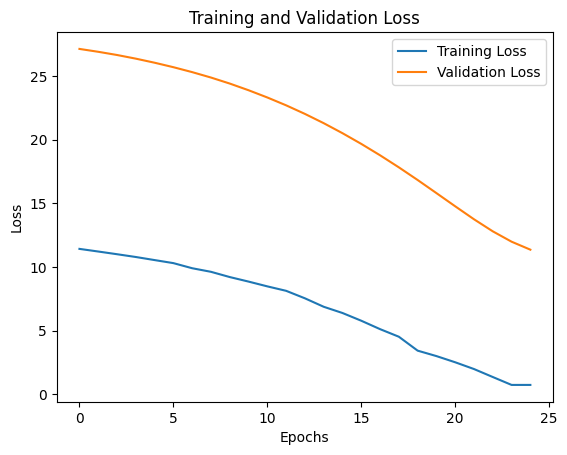

In [ ]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate([test_user_ids, test_movie_ids], test_ratings)
print(f"Test Mean Absolute Error: {test_mae}")

# Plot training and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Step 4.1.5: Make Predictions with the Model

In [ ]:
import numpy as np

# Encode all unique users and movies
filtered_df['user_encoded'] = filtered_df['critic_name'].astype('category').cat.codes
filtered_df['movie_encoded'] = filtered_df['rotten_tomatoes_link'].astype('category').cat.codes

# Create mappings for critic_name and rotten_tomatoes_link to their encoded values
user_id_mapping = dict(zip(filtered_df['critic_name'], filtered_df['user_encoded']))
movie_id_mapping = dict(zip(filtered_df['rotten_tomatoes_link'], filtered_df['movie_encoded']))

def recommend_movies_neural(user_id, top_n=5):
    # Get the encoded user ID
    if user_id not in user_id_mapping:
        return f"User '{user_id}' not found in the dataset."
    user_encoded = user_id_mapping[user_id]

    # Predict ratings for all movies for the given user
    movie_ids = np.array([i for i in range(num_movies)])
    user_ids = np.array([user_encoded for _ in range(num_movies)])
    predicted_ratings = model.predict([user_ids, movie_ids]).flatten()

    # Get top-n recommendations by rating
    top_indices = predicted_ratings.argsort()[-top_n:][::-1]
    recommended_movie_titles = filtered_df['rotten_tomatoes_link'].astype('category').cat.categories[top_indices]

    return recommended_movie_titles

# Test recommendation for a user (replace 'Peter Howell' with an actual user ID in your dataset)
print("Neural Collaborative Filtering Recommendations for user_id 'Peter Howell':")
print(recommend_movies_neural('Peter Howell'))

Neural Collaborative Filtering Recommendations for user_id 'Peter Howell':


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Index(['m/elizabethtown', 'm/ready_player_one', 'm/spotlight_2015',
       'm/runaway_jury', 'm/sexy_beast'],
      dtype='object')


# Step 4.2: Build Deep NLP Models for Content-Based Filtering

## Step 4.2.1: Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

## Step 4.2.2: Load BERT and Tokenizer

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Step 4.2.3: Generate BERT Embeddings for Synopses

In [ ]:
# Function to compute BERT embeddings for a given text
def get_bert_embedding(text):
    # Tokenize the text and get input IDs and attention mask
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Average the last hidden states to get a single embedding vector
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Generate BERT embeddings for all movie synopses in the dataset
synopsis_embeddings = np.array([get_bert_embedding(text) for text in merged_df['cleaned_synopsis']])

## Step 4.2.4: Build a Content-Based Recommender Using BERT Embeddings

In [ ]:
# Compute cosine similarity between BERT embeddings of all movies
synopsis_similarity_bert = cosine_similarity(synopsis_embeddings)

# Function to recommend movies based on BERT-based synopsis similarity
def bert_content_recommendations(movie_title, top_n=5):
    # Find the index of the movie
    movie_idx = merged_df[merged_df['movie_title'].str.lower() == movie_title.lower()].index[0]

    # Get similarity scores for all movies
    sim_scores = list(enumerate(synopsis_similarity_bert[movie_idx]))

    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top_n most similar movies (excluding itself)
    top_movie_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Return the top_n most similar movies
    return merged_df[['movie_title', 'movie_info']].iloc[top_movie_indices]

# Test the BERT-based content recommendation function
print("BERT-based Content Recommendations for 'Sleeping Beauty':")
print(bert_content_recommendations('Sleeping Beauty'))

BERT-based Content Recommendations for 'Sleeping Beauty':
                    movie_title  \
1989            Sleeping Beauty   
1969  The Notorious Bettie Page   
3065               Burn Country   
76      Seducing Charlie Barker   
3430         7 Chinese Brothers   

                                             movie_info  
1989  A college student (Emily Browning) becomes a n...  
1969  Following a failed marriage and a gang rape, B...  
3065  An exiled Afghan journalist moves to Northern ...  
76    An out-of-work actor (Stephen Barker Turner) c...  
3430  Fired from a restaurant, a hard-drinking slack...  


# Step 5: Finalize Recommendation Functions for Easy Access

## Step 5.1: Content-Based Recommendations using BERT Embeddings

In [ ]:
def recommend_content_based(movie_title, top_n=5):
    """Recommend movies based on content similarity using BERT embeddings."""
    try:
        return bert_content_recommendations(movie_title, top_n=top_n)
    except IndexError:
        return f"Movie '{movie_title}' not found in dataset."

## Step 5.2: Collaborative Filtering Recommendations (Non-Neural)

In [ ]:
def recommend_collaborative(user_id, top_n=5):
    """Recommend movies based on collaborative filtering using user similarity."""
    try:
        return collaborative_recommendations(user_id, top_n=top_n)
    except KeyError:
        return f"User '{user_id}' not found in dataset."

## Step 5.3: Neural Collaborative Filtering Recommendations

In [ ]:
def recommend_neural_collaborative(user_id, top_n=5):
    """Recommend movies based on neural collaborative filtering model."""
    try:
        return recommend_movies_neural(user_id, top_n=top_n)
    except KeyError:
        return f"User '{user_id}' not found in dataset."

## Step 5.4: Recommendation Function

In [ ]:
def recommend_movies(method, user_id=None, movie_title=None, top_n=5):
    """
    Unified function to recommend movies based on selected method.

    Parameters:
    - method: 'content_based', 'collaborative', or 'neural_collaborative'
    - user_id: User ID for collaborative and neural collaborative methods
    - movie_title: Movie title for content-based method
    - top_n: Number of recommendations to return

    Returns:
    - List of recommended movies or a message if the user/movie is not found
    """
    if method == 'content_based' and movie_title:
        return recommend_content_based(movie_title, top_n)
    elif method == 'collaborative' and user_id:
        return recommend_collaborative(user_id, top_n)
    elif method == 'neural_collaborative' and user_id:
        return recommend_neural_collaborative(user_id, top_n)
    else:
        return "Please provide a valid method and relevant user_id or movie_title."

## Step 5.5: Test the Recommendation System

In [ ]:
# Example: Content-based recommendations for a specific movie
print("Content-Based Recommendations for 'Sleeping Beauty':")
print(recommend_movies(method='content_based', movie_title='Sleeping Beauty', top_n=5))

# Example: Collaborative filtering recommendations for a specific user
print("\nCollaborative Filtering Recommendations for user_id 'Peter Howell':")
print(recommend_movies(method='collaborative', user_id='Peter Howell', top_n=5))

# Example: Neural collaborative filtering recommendations for a specific user
print("\nNeural Collaborative Filtering Recommendations for user_id 'Peter Howell':")
print(recommend_movies(method='neural_collaborative', user_id='Peter Howell', top_n=5))

Content-Based Recommendations for 'Sleeping Beauty':
                    movie_title  \
1989            Sleeping Beauty   
1969  The Notorious Bettie Page   
3065               Burn Country   
76      Seducing Charlie Barker   
3430         7 Chinese Brothers   

                                             movie_info  
1989  A college student (Emily Browning) becomes a n...  
1969  Following a failed marriage and a gang rape, B...  
3065  An exiled Afghan journalist moves to Northern ...  
76    An out-of-work actor (Stephen Barker Turner) c...  
3430  Fired from a restaurant, a hard-drinking slack...  

Collaborative Filtering Recommendations for user_id 'Peter Howell':
['Elizabethtown', 'Sexy Beast', 'Let Me In', 'Star Trek', 'Secret Window']

Neural Collaborative Filtering Recommendations for user_id 'Peter Howell':
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Index(['m/star_trek_11', 'm/slumdog_millionaire', 'm/secret_window',
       'm/let_me_in', 'm/portrait_of_a_lady_on_fire'],
      